## MIDS - Spotify Base Data Review

In [1]:
## to mount GoogleDrive
from google.colab import drive
import os 
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/to_mount')

Mounted at /content/drive


In [2]:
# base modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import sklearn.metrics

# non-base no import
from pathlib import Path
from bs4 import BeautifulSoup
#from lyricsgenius import Genius
import requests
import seaborn as sns
import json
import xgboost as xgb
import re

In [3]:
#!pip install spotipy
#!pip install pymusixmatch

In [4]:
# import packages
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from musixmatch import Musixmatch
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

In [5]:
nltk.download(["names","stopwords","state_union","twitter_samples","movie_reviews", "averaged_perceptron_tagger","vader_lexicon","punkt"])

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package state_union to /root/nltk_data...
[nltk_data]   Unzipping corpora/state_union.zip.
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
#Spotify creds
cid = Path('_keys/cid.txt').read_text()
secret = Path('_keys/secret.txt').read_text()

#Genius creds
# genius_cid = Path('_keys/genius_cid.txt').read_text()
# genius_secret = Path('_keys/genius_secret.txt').read_text()

#Musixmatch creds
musix_cid = Path('_keys/musix_id.txt').read_text()

In [7]:
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# genius = Genius(genius_cid)

In [8]:
data = pd.read_csv('_data/charts.csv')

In [9]:
data.head()

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0


In [10]:
print(data['chart'].value_counts())
print(data['region'].value_counts())

## suggest narrowing scope to just viral50 in US

top200     20321904
viral50     5851610
Name: chart, dtype: int64
Argentina        455308
United States    455057
Austria          454593
Brazil           454439
Australia        453103
                  ...  
Ukraine          127544
Russia           126837
Luxembourg        98053
Andorra           79592
South Korea       76276
Name: region, Length: 70, dtype: int64


In [11]:
use_songs = data.loc[(data.chart == 'viral50') & 
                     (data.region == 'United States')]

In [ ]:
print("number of unique songs: ", len(use_songs.url.unique()))
print("number of unique artists: ", len(use_songs.artist.unique()))

number of unique songs:  7974
number of unique artists:  4380


In [ ]:
unique_url = use_songs['url'].unique()

In [ ]:
## get spotify data popularity
def popularity(df):
    empty = []
    for i in df:
      #print(i)
      series_track = pd.Series(sp.track(i))
      empty.append(series_track)
    df2 = pd.DataFrame(empty)
    return df2

spotify_pull = popularity(unique_url)

In [16]:
spotify_pull.head()

,Unnamed: 0,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,0,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT...",1,218319,False,{'isrc': 'GBBPW1700118'},{'spotify': 'https://open.spotify.com/track/6X...,https://api.spotify.com/v1/tracks/6XgtAeRYmbr4...,6XgtAeRYmbr4OfEUP3q0D3,False,LMK,23,https://p.scdn.co/mp3-preview/f45c9bfa1065769d...,1,track,spotify:track:6XgtAeRYmbr4OfEUP3q0D3
1,1,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AG', 'AM', 'AO', 'AR', 'AT', 'AU...",1,199741,True,{'isrc': 'TCADD1721892'},{'spotify': 'https://open.spotify.com/track/2A...,https://api.spotify.com/v1/tracks/2AEzMPR01sg1...,2AEzMPR01sg1wsXurYrgDx,False,Turn Up On the Weekend,38,https://p.scdn.co/mp3-preview/c21e5b0857dfd30e...,1,track,spotify:track:2AEzMPR01sg1wsXurYrgDx
2,2,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT...",1,234285,False,{'isrc': 'USAT21702382'},{'spotify': 'https://open.spotify.com/track/57...,https://api.spotify.com/v1/tracks/57p8CBvPOxrv...,57p8CBvPOxrvyCbn6ttl5r,False,Would You Ever,61,https://p.scdn.co/mp3-preview/31ee7b84a59f1062...,1,track,spotify:track:57p8CBvPOxrvyCbn6ttl5r
3,3,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,[],1,261614,True,{'isrc': 'QZ8TY1700008'},{'spotify': 'https://open.spotify.com/track/0R...,https://api.spotify.com/v1/tracks/0RYXEibxMami...,0RYXEibxMami3QuT8kn4Iz,False,Marmalade (feat. Lil Yachty),0,NaN,1,track,spotify:track:0RYXEibxMami3QuT8kn4Iz
4,4,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT...",1,162585,False,{'isrc': 'GBAHS1700564'},{'spotify': 'https://open.spotify.com/track/5o...,https://api.spotify.com/v1/tracks/5o4yGlG0PfeV...,5o4yGlG0PfeVUa6ClIyOxq,False,Boys,62,https://p.scdn.co/mp3-preview/7de075b189146e50...,1,track,spotify:track:5o4yGlG0PfeVUa6ClIyOxq


In [ ]:
spotify_pull.to_csv('viral50_use.csv')

In [12]:
spotify_pull = pd.read_csv('viral50_use.csv')

In [23]:
# parse url from JSON response
def parse_url(df):
  empty = []
  for i in df['external_urls']:
    line_artists = []
    try:
      artist_lists = json.loads(i.replace("\'", "\""))
    except:
      artists_lists = []
    line_artists.append(artist_lists['spotify'])
    empty.append(line_artists)
  return empty


spotify_pull['full_url'] = parse_url(spotify_pull)
spotify_pull['url'] = spotify_pull.apply(lambda row: row.full_url[0], axis=1)

In [24]:
spotify_pull.head()

,Unnamed: 0,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri,url,full_url
0,0,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT...",1,218319,False,{'isrc': 'GBBPW1700118'},{'spotify': 'https://open.spotify.com/track/6X...,https://api.spotify.com/v1/tracks/6XgtAeRYmbr4...,6XgtAeRYmbr4OfEUP3q0D3,False,LMK,23,https://p.scdn.co/mp3-preview/f45c9bfa1065769d...,1,track,spotify:track:6XgtAeRYmbr4OfEUP3q0D3,https://open.spotify.com/track/6XgtAeRYmbr4OfE...,[https://open.spotify.com/track/6XgtAeRYmbr4Of...
1,1,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AG', 'AM', 'AO', 'AR', 'AT', 'AU...",1,199741,True,{'isrc': 'TCADD1721892'},{'spotify': 'https://open.spotify.com/track/2A...,https://api.spotify.com/v1/tracks/2AEzMPR01sg1...,2AEzMPR01sg1wsXurYrgDx,False,Turn Up On the Weekend,38,https://p.scdn.co/mp3-preview/c21e5b0857dfd30e...,1,track,spotify:track:2AEzMPR01sg1wsXurYrgDx,https://open.spotify.com/track/2AEzMPR01sg1wsX...,[https://open.spotify.com/track/2AEzMPR01sg1ws...
2,2,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT...",1,234285,False,{'isrc': 'USAT21702382'},{'spotify': 'https://open.spotify.com/track/57...,https://api.spotify.com/v1/tracks/57p8CBvPOxrv...,57p8CBvPOxrvyCbn6ttl5r,False,Would You Ever,61,https://p.scdn.co/mp3-preview/31ee7b84a59f1062...,1,track,spotify:track:57p8CBvPOxrvyCbn6ttl5r,https://open.spotify.com/track/57p8CBvPOxrvyCb...,[https://open.spotify.com/track/57p8CBvPOxrvyC...
3,3,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,[],1,261614,True,{'isrc': 'QZ8TY1700008'},{'spotify': 'https://open.spotify.com/track/0R...,https://api.spotify.com/v1/tracks/0RYXEibxMami...,0RYXEibxMami3QuT8kn4Iz,False,Marmalade (feat. Lil Yachty),0,NaN,1,track,spotify:track:0RYXEibxMami3QuT8kn4Iz,https://open.spotify.com/track/0RYXEibxMami3Qu...,[https://open.spotify.com/track/0RYXEibxMami3Q...
4,4,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT...",1,162585,False,{'isrc': 'GBAHS1700564'},{'spotify': 'https://open.spotify.com/track/5o...,https://api.spotify.com/v1/tracks/5o4yGlG0PfeV...,5o4yGlG0PfeVUa6ClIyOxq,False,Boys,62,https://p.scdn.co/mp3-preview/7de075b189146e50...,1,track,spotify:track:5o4yGlG0PfeVUa6ClIyOxq,https://open.spotify.com/track/5o4yGlG0PfeVUa6...,[https://open.spotify.com/track/5o4yGlG0PfeVUa...


In [31]:
max_position = use_songs.groupby('url').agg({'rank': 'min'})
max_position.reset_index()

spotify_pull_join = pd.merge(spotify_pull.reset_index(),
                            max_position.reset_index(),
                            how='left', 
                            on = 'url')

Plot distribution of popularity score.

[Text(0.5, 1.0, 'Total Popularity Distribution')]

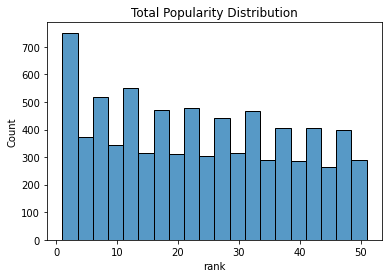

In [33]:
sns.histplot(data = spotify_pull_join
            ,x = 'rank'
            ).set(title='Total Popularity Distribution')

In [35]:
# parse artist names from JSON response
def parse_artist(df):
  empty = []
  for i in df['artists']:
    line_artists = []
    try:
      artist_lists = json.loads(i.replace("\'", "\""))
    except:
      #print(i)
      artists_lists = []
    for j in artist_lists:
      line_artists.append(j['name'])
    empty.append(line_artists)
  return empty


spotify_pull_join['artist_names'] = parse_artist(spotify_pull_join)
spotify_pull_join['first_artist'] = spotify_pull_join.apply(lambda row: row.artist_names[0], axis=1)

In [36]:
out = pd.DataFrame(spotify_pull_join.first_artist.value_counts())
out.head(10)

,first_artist
Drake,63
Logic,34
Prince,32
DMX,29
Ed Sheeran,28
Juice WRLD,26
Post Malone,25
Billie Eilish,25
Chris Stapleton,23
Mac Miller,23


[Text(0.5, 1.0, 'Arist Song Count')]

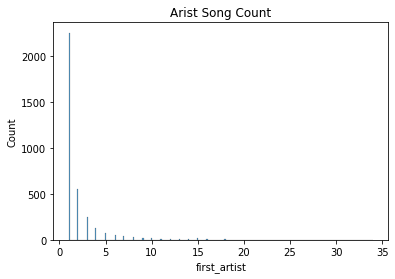

In [37]:
sns.histplot(data = out.loc[out['first_artist'] < 40]
            ,x = 'first_artist'
            ).set(title='Arist Song Count')

In [38]:
use_cols = ['href', 'rank', 'name', 'first_artist']
electro_short_join = spotify_pull_join[use_cols]

In [39]:
electro_short_join.head()

,href,rank,name,first_artist
0,https://api.spotify.com/v1/tracks/6XgtAeRYmbr4...,32,LMK,Kelela
1,https://api.spotify.com/v1/tracks/2AEzMPR01sg1...,1,Turn Up On the Weekend,Branchez
2,https://api.spotify.com/v1/tracks/57p8CBvPOxrv...,2,Would You Ever,Skrillex
3,https://api.spotify.com/v1/tracks/0RYXEibxMami...,3,Marmalade (feat. Lil Yachty),Macklemore
4,https://api.spotify.com/v1/tracks/5o4yGlG0PfeV...,4,Boys,Charli XCX


In [118]:
## Create dictionary to track model results
results = {}

def add_results(y_pred, model_name):
    ## Add results of test data to tracker, with user input to ensure data is overwritten on purpose
    if model_name in results.keys():
        userIn = input("Model already in dictionary. Add? ").lower()
        if userIn == 'yes':
            results[model_name] = round(sklearn.metrics.roc_auc_score(y_test, y_pred), 4)
        else:
            pass
    else:
        results[model_name] = round(sklearn.metrics.roc_auc_score(y_test, y_pred), 4)
    print(results)

## pull from MusixMatch

In [41]:
musixmatch = Musixmatch(musix_cid)

def parse_lyrics(df):
  empty = []
  for row, artist in df.first_artist.iteritems():
    song_title = df['name'].loc[row]
    lyrics_return = ''
    #print(song_title)
    #print(artist)
    try:
      track_return = musixmatch.matcher_track_get(song_title, artist)
      if track_return['message']['body']['track']['has_lyrics'] == 1:
        lyrics_return = musixmatch.track_lyrics_get(track_return['message']['body']['track']['track_id'])['message']['body']['lyrics']['lyrics_body']
    except:
      lyrics_return = ''
    empty.append(lyrics_return)
  return empty

full_lyrics = parse_lyrics(electro_short_join)

In [42]:
electro_short_join['lyrics'] = full_lyrics

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [96]:
## clean lyrics
electro_short_join['lyrics_clean'] = electro_short_join['lyrics'].str.replace('******* This Lyrics is NOT for Commercial use *******\n(1409622602394)', '',regex=False).str.replace('\n', ' ', regex=False)
electro_short_join['char_len'] = electro_short_join['lyrics_clean'].str.len()

In [44]:
electro_short_join.to_csv('rank_viral_w_lyrics.csv')

In [97]:
electro_short_join = pd.read_csv('rank_viral_w_lyrics.csv')

In [98]:
# prep sentiment analysis
sia = SentimentIntensityAnalyzer()

In [99]:
def get_sentiment(df):
  empty = []

  for lyrics in df.lyrics_clean:

    if pd.isna(lyrics):
      lyrics = ''

    #print(lyrics)
    output = sia.polarity_scores(lyrics)
    empty.append(output)
    
  return empty

sentiment_scores = pd.DataFrame(get_sentiment(electro_short_join))
final_sentiment = pd.concat([electro_short_join.reset_index(), sentiment_scores.reset_index()], axis=1)

In [100]:
## bring in GloVe
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

glove_filename = 'glove.6B.50d.txt'

word2vec_output_file = glove_filename+'.word2vec'
glove2word2vec('glove.6B.50d.txt', word2vec_output_file)

# load the Stanford GloVe model
word2vec_output_file = glove_filename+'.word2vec'
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [101]:
v = model.get_vector('king')
D = v.shape[0]

X = np.zeros((len(final_sentiment.lyrics_clean), D))
n = 0
emptycount = 0

for sentence in final_sentiment.lyrics_clean:
  
  if pd.isna(sentence):
    sentence = ''
  
  tokens = sentence.split()
  vecs = []
  m = 0
  
  for word in tokens:
    word = word.lower()
    try:
      # throws KeyError if word not found
      vec = model.get_vector(word)
      vecs = np.append(vecs, vec)
      m += 1
    except KeyError:
      pass
    
  if len(vecs) > 0:
    vecs = np.array(vecs)
    X[n] = vecs.mean(axis=0)
  else:
    emptycount += 1  
  n += 1

print(emptycount)
print(n)

1061
7974


In [113]:
df_GloVe = pd.DataFrame(X)
df_GloVe.columns = ['GloVe' + str(x) for x in range(50)]

final_sentiment2 = pd.concat([final_sentiment.reset_index(), df_GloVe.reset_index()], axis=1)
final_sentiment2['target'] = np.where(final_sentiment2['rank'] <= 15, 1, 0)

In [114]:
use_cols = ['neg', 'neu', 'pos', 'compound','GloVe0','GloVe1','GloVe2','GloVe3','GloVe4',
            'GloVe5','GloVe6','GloVe7','GloVe8','GloVe9','GloVe10','GloVe11','GloVe12',
            'GloVe13','GloVe14','GloVe15','GloVe16','GloVe17','GloVe18','GloVe19','GloVe20','GloVe21','GloVe22',
            'GloVe23','GloVe24','GloVe25','GloVe26','GloVe27','GloVe28','GloVe29','GloVe30','GloVe31',
            'GloVe32','GloVe33','GloVe34','GloVe35','GloVe36','GloVe37','GloVe38','GloVe39','GloVe40',
            'GloVe41','GloVe42','GloVe43','GloVe44','GloVe45','GloVe46','GloVe47','GloVe48','GloVe49',
            'target']

In [115]:
electro_agg_metrics = final_sentiment2[use_cols]

In [116]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(electro_agg_metrics.drop('target', axis = 1), 
                                                                            electro_agg_metrics.target,
                                                    random_state = 1111,
                                                    test_size = 0.3)

In [119]:
XGB_MVP = xgb.XGBClassifier(objective='binary:logistic',
                                seed=100).fit(X_train, y_train)
add_results(XGB_MVP.predict(X_test), "XGB_Base_lyrics")

{'XGB_Base_lyrics': 0.5023}


In [120]:
## Run GridSearchCV on max_depth, min_child_weight, n_estimators, and subsample

param_test = {
 'max_depth':range(2,5,1),
 'min_child_weight':range(3,10,2),
 'subsample':[i/100.0 for i in range(70,90,5)],
 'n_estimator':range(150,300,50)
}

gsearch1 = sklearn.model_selection.GridSearchCV(estimator=xgb.XGBRegressor(objective='binary:logistic', eta=0.05,
                                                                           seed=100),param_grid=param_test, 
                                                                           cv=4)
gsearch1.fit(X_train, y_train)
gsearch1.best_estimator_

XGBRegressor(eta=0.05, max_depth=2, min_child_weight=9, n_estimator=150,
             objective='binary:logistic', seed=100, subsample=0.75)

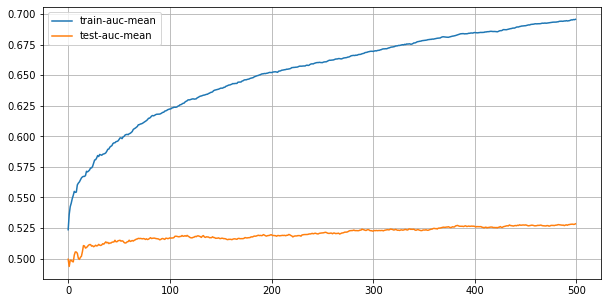

In [122]:
## Select final number of estimators
params = {'eta':0.05, 'seed':100, 
         'max_depth':2, 'min_child_weight':9, 'subsample':0.75, 'objective':'binary:logistic'}

## Run CV to determine the number of round
CVRun = xgb.cv(
            params=params,
            dtrain=xgb.DMatrix(X_train, label=y_train),
            num_boost_round=500,
            nfold=4,
            metrics='auc',
            seed=100)

CVRun.drop(['train-auc-std', 'test-auc-std'], axis=1, inplace=True)
CVRun.plot(figsize = (10,5), grid = True)

In [123]:
## Selected 300 as the number of rounds to avoid over fitting

XGB_hyperparam = xgb.train(params, xgb.DMatrix(X_train, label=y_train), 300)
add_results(XGB_hyperparam.predict(xgb.DMatrix(X_test)), "XGB_Hyperparam_lyrics")

{'XGB_Base_lyrics': 0.5023, 'XGB_Hyperparam_lyrics': 0.5057}


In [124]:
non_zero = electro_agg_metrics.loc[electro_agg_metrics.GloVe46 != 0]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(non_zero.drop('target', axis = 1), 
                                                                            non_zero.target,
                                                    random_state = 1111,
                                                    test_size = 0.3)

In [125]:
XGB_MVP = xgb.XGBRegressor(objective='binary:logistic',
                                seed=100).fit(X_train, y_train)
add_results(XGB_MVP.predict(X_test), "XGB_Base_lyrics_nonZero")

{'XGB_Base_lyrics': 0.5023, 'XGB_Hyperparam_lyrics': 0.5057, 'XGB_Base_lyrics_nonZero': 0.5238}


In [126]:
## Selected 300 as the number of rounds to avoid over fitting

XGB_hyperparam = xgb.train(params, xgb.DMatrix(X_train, label=y_train), 300)
add_results(XGB_hyperparam.predict(xgb.DMatrix(X_test)), "XGB_Hyperparam_lyrics_nonZero")

{'XGB_Base_lyrics': 0.5023, 'XGB_Hyperparam_lyrics': 0.5057, 'XGB_Base_lyrics_nonZero': 0.5238, 'XGB_Hyperparam_lyrics_nonZero': 0.5177}
